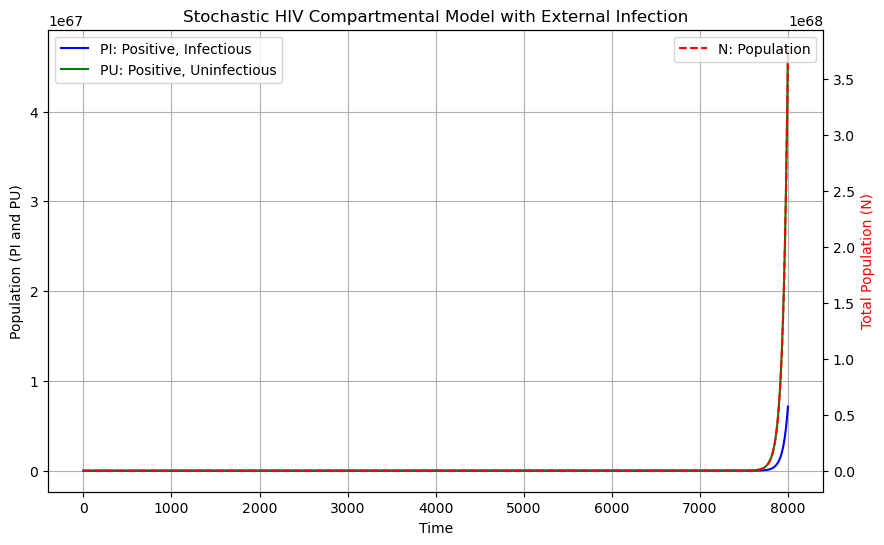

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint



def model_stochastic(y, t, alpha, beta, mu, delta_PI, delta_PU, lambda_, T, gamma, sigma, sigma_beta):
    """
    Stochastic compartmental model for HIV transmission.
    """
    
    U, PI, PU, N = y
    
    # Introduce noise to the infection rate for added stochasticity
    beta_stochastic = beta + np.random.normal(0, sigma_beta)
    T_stochastic = np.random.exponential(scale=T, size=None) #result time
    
    # U compartment (Uninfected)
    # Gained: Population growth rate (alpha * N)
    # Lost: Infection by PI individuals (beta_stochastic * U * PI/N)
    # Lost: Natural deaths (mu * U)
    dUdt = alpha * N - beta_stochastic * U * PI/N - mu * U
    
    # PI compartment (Positive Infectious)
    # Gained: New infections from U compartment (beta_stochastic * U * PI/N)
    # Gained: Transitions from PU due to reinfection (gamma * PU)
    # Gained: Continuous external source of infection (sigma * N)
    # Lost: Transition to PU due to testing (lambda_/T * PI)
    # Lost: Natural deaths (mu * PI)
    # Lost: Disease-specific deaths (delta_PI * PI)
    dPIdt = beta_stochastic * U * PI/N + gamma * PU + sigma * N - lambda_/T * PI - mu * PI - delta_PI * PI
    #Stochastic T version (breaks everything):
    #dPIdt = beta_stochastic * U * PI/N + gamma * PU + sigma * N - lambda_/T_stochastic * PI - mu * PI - delta_PI * PI
    
    
    # PU compartment (Positive Uninfectious)
    # Gained: Transitions from PI due to testing (lambda_/T * PI)
    # Lost: Reinfections transitioning back to PI (gamma * PU)
    # Lost: Natural deaths (mu * PU)
    # Lost: Disease-specific deaths (delta_PU * PU)
    dPUdt = lambda_/T * PI - gamma * PU - mu * PU - delta_PU * PU
    #Stochastic T version (breaks everything):
    #dPUdt = lambda_/T_stochastic * PI - gamma * PU - mu * PU - delta_PU * PU
    
    # N compartment (Total Population)
    # Sum of changes in all compartments (dUdt + dPIdt + dPUdt)
    dNdt = dUdt + dPIdt + dPUdt  
    
    return [dUdt, dPIdt, dPUdt, dNdt]

# Initial conditions
N0 = 200000
PI0 = 0.001*N0
PU0 = 0.0029*N0
U0 = N0 - PU0 - PI0

# Set model parameters
alpha = 0.02 #population growth rate
beta = 0.2#transmission rate
mu = 1/1000 #death rate (avg 18-50 ish)
delta_PI = 0.05 #infected additional death rate
delta_PU = 0.00 #non-infected additional death rate
lambda_ = 0.9 #probability of transitioning from PI to PU upon testing
T = 7 #result time
gamma = 0.0001 
sigma = 0.0005  # External source of infection
sigma_beta = 0.0001  # Noise in infection rate



# Define time vector
t = np.linspace(0, 8000, 4000)

# Solve the ODE using a loop due to stochastic nature
dt = t[1] - t[0]
y = [U0, PI0, PU0, N0]
solution_stochastic = [y]
for ti in t[1:]:
    dy = model_stochastic(y, ti, alpha, beta, mu, delta_PI, delta_PU, lambda_, T, gamma, sigma, sigma_beta)
    y_new = [y[j] + dy[j]*dt for j in range(4)]
    solution_stochastic.append(y_new)
    y = y_new

solution_stochastic = np.array(solution_stochastic)

# Plot the results
plt.figure(figsize=(10, 6))
ax1 = plt.gca()

# Plotting Positive Infectious and Positive Uninfectious populations
ax1.plot(t, solution_stochastic[:, 1], label='PI: Positive, Infectious', color='blue')
ax1.plot(t, solution_stochastic[:, 2], label='PU: Positive, Uninfectious', color='green')
ax1.set_xlabel('Time')
ax1.set_ylabel('Population (PI and PU)', color='black')
ax1.legend(loc='upper left')
ax1.grid(True)

# Create secondary axis for total population
ax2 = ax1.twinx()
ax2.plot(t, solution_stochastic[:, 3], label='N: Population', color='red', linestyle='--')
ax2.set_ylabel('Total Population (N)', color='red')
ax2.legend(loc='upper right')

plt.title('Stochastic HIV Compartmental Model with External Infection')
plt.show()


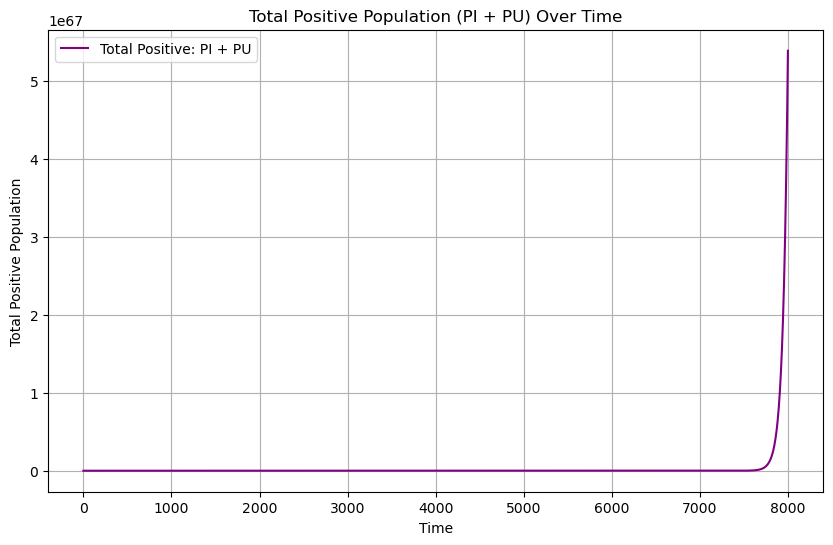

In [2]:
# Calculate total positive population (PI + PU)
total_positive = solution_stochastic[:, 1] + solution_stochastic[:, 2]

# Plotting the total positive population over time
plt.figure(figsize=(10, 6))
plt.plot(t, total_positive, label='Total Positive: PI + PU', color='purple')
plt.xlabel('Time')
plt.ylabel('Total Positive Population')
plt.title('Total Positive Population (PI + PU) Over Time')
plt.legend()
plt.grid(True)
plt.show()

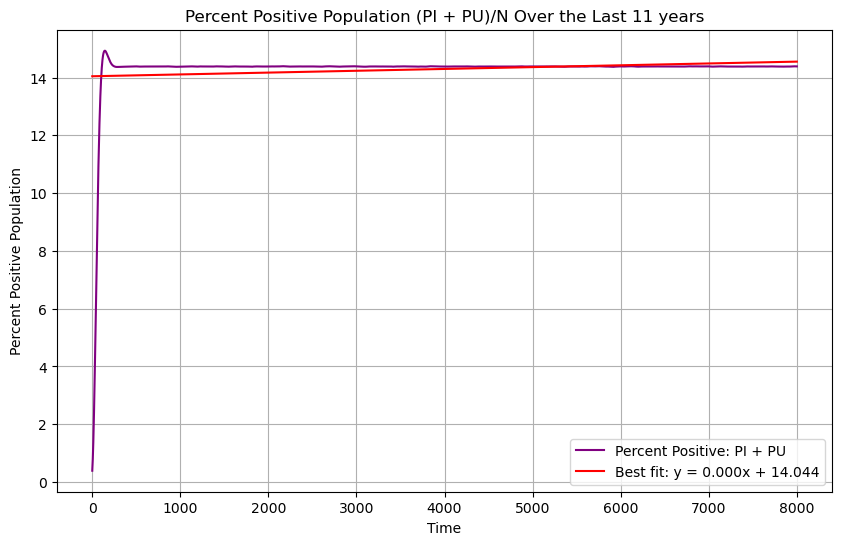

In [3]:
# Calculate total positive population (PI + PU)
percent_positive = 100*(solution_stochastic[:, 1] + solution_stochastic[:, 2])/solution_stochastic[:,3]

# Limit the time values and percent_positive values to the last n years
n=11
last_n_years_days = t[-365*n:]
percent_positive_last_n_years = percent_positive[-365*n:]

# Compute the best fit line
slope, intercept = np.polyfit(last_n_years_days, percent_positive_last_n_years, 1)
best_fit = slope * last_n_years_days + intercept

# Plotting the percent positive population for the last 4 years
plt.figure(figsize=(10, 6))
plt.plot(last_n_years_days, percent_positive_last_n_years, label='Percent Positive: PI + PU', color='purple')
plt.plot(last_n_years_days, best_fit, 'r-', label=f'Best fit: y = {slope:.3f}x + {intercept:.3f}')

plt.xlabel('Time')
plt.ylabel('Percent Positive Population')
plt.title('Percent Positive Population (PI + PU)/N Over the Last '+ str(n)+' years')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
print("The intercept is", intercept, "for T=", T)

The intercept is 14.043775560721409 for T= 7


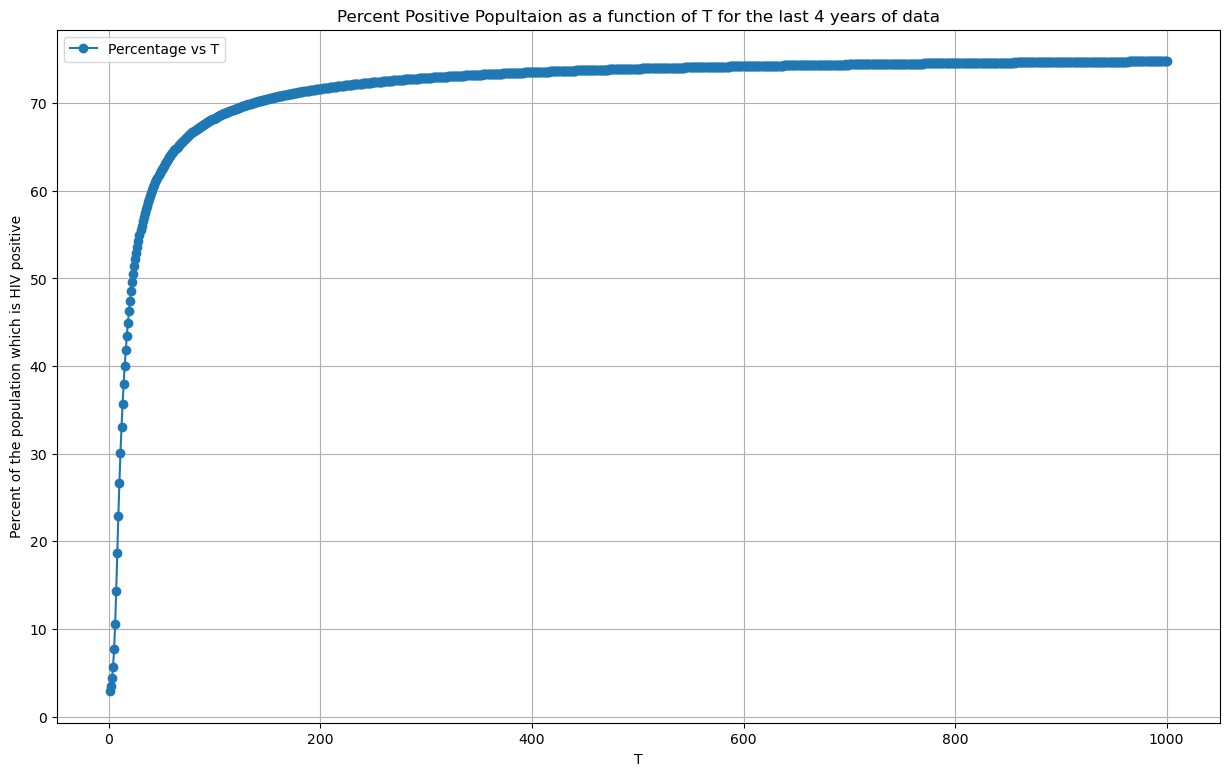

In [7]:
# Initial conditions
N0 = 200000
PI0 = 0.001*N0
PU0 = 0.0029*N0
U0 = N0 - PU0 - PI0

# Set model parameters
alpha = 0.02 #population growth rate
beta = 0.2#transmission rate
mu = 1/1000 #death rate (avg 18-50 ish)
delta_PI = 0.05 #infected additional death rate
delta_PU = 0.00 #non-infected additional death rate
lambda_ = 0.9 #probability of transitioning from PI to PU upon testing
T = 7 #result time
gamma = 0.0001 
sigma = 0.0005  # External source of infection
sigma_beta = 0.0001  # Noise in infection rate


# Define time vector
t = np.linspace(0, 8000, 4000)

intercepts=[]
T_values = np.linspace(1, 1000, 1000)  # This is just an example

# For each T, solve the model, compute linear regression for the last 4 years and get the intercept
for T in T_values:
    # Solve the ODE using a loop due to stochastic nature
    dt = t[1] - t[0]
    y = [U0, PI0, PU0, N0]
    solution_stochastic = [y]
    for ti in t[1:]:
        dy = model_stochastic(y, ti, alpha, beta, mu, delta_PI, delta_PU, lambda_, T, gamma, sigma, sigma_beta)
        y_new = [y[j] + dy[j]*dt for j in range(4)]
        solution_stochastic.append(y_new)
        y = y_new

    solution_stochastic = np.array(solution_stochastic)
    # Calculate total positive population (PI + PU)
    percent_positive = 100*(solution_stochastic[:, 1] + solution_stochastic[:, 2])/solution_stochastic[:,3]

    # Limit the time values and percent_positive values to the last 4 years
    last_4_years_days = t[-365*4:]
    percent_positive_last_4_years = percent_positive[-365*4:]

    # Compute the best fit line
    slope, intercept = np.polyfit(last_4_years_days, percent_positive_last_4_years, 1)
    intercepts.append(intercept)


# Now, plot intercept as a function of T
plt.figure(figsize=(15, 9))
plt.plot(T_values, intercepts, 'o-', label='Percentage vs T')
plt.xlabel('T')
plt.ylabel('Percent of the population which is HIV positive')
plt.title('Percent Positive Popultaion as a function of T for the last 4 years of data')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
#KW: approx 15% of the gay, sexually active pop is pos. No ref provided. 
#Assume that average result time is 7 days 